<a href="https://colab.research.google.com/github/marcusmvfa/Covid-19Forecast/blob/main/CovidForecastTCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primeiro Seleciono os arquivos com os dados

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean


In [2]:
# file = tf.keras.utils.get_file(origin="https://raw.githubusercontent.com/marcusmvfa/Covid-19Forecast/main/soFoize.csv",fname='soFoize.csv', extract=True)

# df = pd.read_csv(Teste1, sep=',',encoding='UTF-8', error_bad_lines=False, infer_datetime_format=True)

# df['date'] = pd.to_datetime(df['date'])

# df = df.drop(columns=['epi_week', 'last_info_date', '_source', 'country','state','city', 'date'])


In [3]:
file = tf.keras.utils.get_file(origin="https://raw.githubusercontent.com/marcusmvfa/Covid-19Forecast/main/soFoize.csv",fname='soFoize.csv', extract=True)

df = pd.read_csv(file, sep=',',encoding='UTF-8', error_bad_lines=False, infer_datetime_format=True)
df['date'] = pd.to_datetime(df['date'])  
# mask = df['date'] <= '2020-12-18'
# df = df.loc[mask]
df = df.drop(columns=['epi_week', 'last_info_date', '_source', 'country','state','city', 'date'])
# df["date"] = pd.to_datetime(df["date"])

81920/70659 [==================================] - 0s 0us/step


In [4]:
# df.drop(columns=['epi_week'])
df.head()
df.dtypes

ibgeID                               int64
newDeaths                            int64
deaths                               int64
newCases                             int64
totalCases                           int64
deaths_per_100k_inhabitants        float64
totalCases_per_100k_inhabitants    float64
deaths_by_totalCases               float64
dtype: object

In [5]:
# df.plot(x='date', y=['newCases'], grid=True);

# df.loc[df.index == 505, 'newCases'] = 500


In [6]:
target_name = ['newCases']

In [7]:
shift_steps = 30

In [8]:
df_targets = df[target_name].shift(-shift_steps)


In [9]:
df_targets

,newCases
0,0.0
1,3.0
2,-1.0
3,0.0
4,0.0
...,...
608,NaN
609,NaN
610,NaN
611,NaN


In [10]:
df[target_name].head(shift_steps + 5)

,newCases
0,1
1,0
2,0
3,0
4,3
5,0
6,0
7,1
8,0
9,0


In [11]:
df_targets.head(5)

,newCases
0,0.0
1,3.0
2,-1.0
3,0.0
4,0.0


In [12]:
df_targets.tail()


,newCases
608,NaN
609,NaN
610,NaN
611,NaN
612,NaN


In [13]:
x_data = df.values[0:-shift_steps]
x_data


array([[4.10830400e+06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.87640000e-01, 0.00000000e+00],
       [4.10830400e+06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.87640000e-01, 0.00000000e+00],
       [4.10830400e+06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.87640000e-01, 0.00000000e+00],
       ...,
       [4.10830400e+06, 0.00000000e+00, 1.16100000e+03, ...,
        4.50050590e+02, 1.74217257e+04, 2.58300000e-02],
       [4.10830400e+06, 0.00000000e+00, 1.16100000e+03, ...,
        4.50050590e+02, 1.74217257e+04, 2.58300000e-02],
       [4.10830400e+06, 0.00000000e+00, 1.16100000e+03, ...,
        4.50050590e+02, 1.74217257e+04, 2.58300000e-02]])

In [14]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (583, 8)


In [15]:
y_data = df_targets.values[:-shift_steps]


In [16]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (583, 1)


Número de observações

In [17]:
num_data = len(x_data)
num_data

583

In [18]:
train_split = 0.9

In [19]:
num_train = int(train_split * num_data)
num_train

524

In [20]:
num_test = num_data - num_train
num_test

59

In [21]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

583

In [22]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

583

In [23]:
num_x_signals = x_data.shape[1]
num_x_signals

8

In [24]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [25]:
df.dtypes

ibgeID                               int64
newDeaths                            int64
deaths                               int64
newCases                             int64
totalCases                           int64
deaths_per_100k_inhabitants        float64
totalCases_per_100k_inhabitants    float64
deaths_by_totalCases               float64
dtype: object

In [26]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -530.0
Max: 4108304.0


In [27]:
x_scaler = MinMaxScaler()


In [28]:
x_train_scaled = x_scaler.fit_transform(x_train)


In [29]:

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [30]:
x_test_scaled = x_scaler.transform(x_test)


In [31]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [32]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(524, 8)
(524, 1)


In [33]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [34]:
batch_size = 256


In [35]:
sequence_length = 30 * 2
sequence_length

60

In [36]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [37]:
x_batch, y_batch = next(generator)


In [38]:
print(x_batch.shape)
print(y_batch.shape)

(256, 60, 8)
(256, 60, 1)


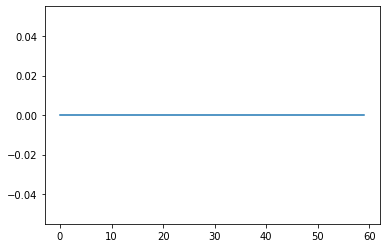

In [39]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

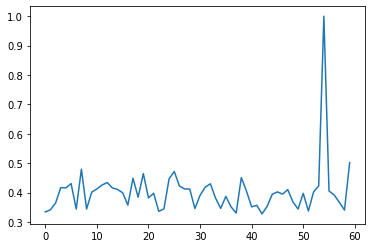

In [40]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [41]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [42]:
model = Sequential()


In [43]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [44]:
model.add(Dense(num_y_signals, activation='sigmoid'))


In [45]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [46]:
warmup_steps = 50


In [47]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [48]:
optimizer = RMSprop(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [49]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 512)         801792    
                                                                 
 dense (Dense)               (None, None, 1)           513       
                                                                 
Total params: 802,305
Trainable params: 802,305
Non-trainable params: 0
_________________________________________________________________


In [51]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [52]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [53]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [54]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [55]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [ ]:
%%time
model.fit(x=generator,
          epochs=10,
          steps_per_epoch=75,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 0.0044
Epoch 00001: val_loss improved from inf to 0.00043, saving model to 23_checkpoint.keras
75/75 [==============================] - 142s 2s/step - loss: 0.0044 - val_loss: 4.2613e-04 - lr: 0.0010
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.0036
Epoch 00002: val_loss did not improve from 0.00043

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 [==============================] - 138s 2s/step - loss: 0.0036 - val_loss: 0.0022 - lr: 0.0010
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.0034
Epoch 00003: val_loss improved from 0.00043 to 0.00023, saving model to 23_checkpoint.keras
75/75 [==============================] - 141s 2s/step - loss: 0.0034 - val_loss: 2.3019e-04 - lr: 1.0000e-04
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 0.0031
Epoch 00004: val_loss did not improve from 0.00023

Epoch 00004: ReduceL

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

In [ ]:
print("loss (test-set):", result)


In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_name)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_name[signal])
        plt.legend()
        plt.show()

In [ ]:
plot_comparison(start_idx=150, length=1000, train=True)
